In [1]:
from cobrascape.species import save_json_obj, load_json_obj
from cobra.io import load_json_model
from cobra import Reaction
from cobra import flux_analysis
import numpy as np
from cobra.io import save_json_model
from cobrascape.species import create_action_set
import matplotlib.pyplot as plt
import cobrascape.species as cs

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
def add_exchange_reaction(mod_, metab_list, prefix_id="EX"):
    """Take in a model and add metabolite drain reactions for a list of metabolites
    in the model. These metabolite drain reactions will have the identification
    of (MDS)__(metabolite id). (i.e., MDS__atp_c for the atp_c metabolite)
    """
    mod = mod_.copy()
    metab_obj_names=[]
    for metab in metab_list:
        obj_name = prefix_id+"_"+metab.strip("_e").strip("_c")
        metab_drain = Reaction(obj_name)
        metab_drain.lower_bound = 0
        metab_drain.upper_bound = 1000.
        metab_drain.add_metabolites({mod.metabolites.get_by_id(metab): 1.0})
        mod.add_reaction(metab_drain)
        metab_obj_names.append(obj_name)
    return mod, metab_obj_names

# COBRA_MODEL, metab_names = add_exchange_reaction(COBRA_MODEL, ["k_e"], prefix_id="EX")

def plot_setup(row_num=1, col_num=1, s_size=100, labelsizes=20, f_scale=1.0, figSIZE=(7,5)):
    
    rc_par = {"axes.labelsize": labelsizes, "xtick.labelsize":labelsizes, 
              "ytick.labelsize":labelsizes,"axes.titlesize":labelsizes}
    # savefig=True
    with sns.plotting_context("notebook", font_scale=f_scale, rc=rc_par):
        f, ax = plt.subplots(row_num, col_num, figsize=figSIZE)
        return f, ax
    
def flux_constraint_hist(samps, action_list, rxn_list=["CAT"]):
    
    rxns_constraint_dict = {}
    
    for react in rxn_list:#player_reacts: # "FAS161", "DCPT", "AFE"
        rxns_constraint_dict[react] = {}
        max_flux, min_flux = max(samps[react]), min(samps[react])
        mean_flux = np.mean(samps[react])
    
        action_to_constraints_dict = {}
        # for reactions that can't have any change, keep their bounds at a single value.
        if max_flux == min_flux: 
            for a in action_list:
                action_to_constraints_dict.update({a: max_flux})
        else:
            left_bound_distance = mean_flux - min_flux

            gradient_steps = int(len(action_list)/2)
            # min_to_mean_grad = np.arange(min_flux, mean_flux, (mean_flux-min_flux)/gradient_steps)
            # max_to_mean_grad = np.arange(mean_flux, max_flux, (max_flux-mean_flux)/gradient_steps)
            min_to_mean_grad = np.arange(min_flux, mean_flux, (mean_flux-min_flux)/(gradient_steps+1))[-gradient_steps:]
            max_to_mean_grad = np.arange(mean_flux, max_flux, (max_flux-mean_flux)/(gradient_steps+1))[-gradient_steps:]

            for a in action_list:
                if a == "no_change":
                    action_to_constraints_dict.update({a: 0})
                else:
                    dec_or_inc = a.split("_")[0]
                    grad_dist = int(a.split("_")[1])

                    # It doesn't matter if mean_flux is less than or greater than 0.
                    if dec_or_inc == "lb": # Change upper_bound
                        action_to_constraints_dict.update({a: min_to_mean_grad[grad_dist]})
                    elif dec_or_inc == "ub": # Change lower_bound
                        action_to_constraints_dict.update({a: max_to_mean_grad[grad_dist]})

        rxns_constraint_dict[react].update(action_to_constraints_dict)
        
        
    ### Plot
    rxn_id = react# "FAD_20"# "ASNt2r"#"ICL"# "EMB"# "DCPT"# "CAT"
    f, ax = plot_setup(row_num=1, col_num=1, s_size=100, labelsizes=20, f_scale=1.0, figSIZE=(7,5))
    samps[rxn_id].hist(bins=100, alpha=0.5, ax=ax)
    ax.set_title(rxn_id)
    mean_flux=samps[rxn_id].mean()
    std_flux=samps[rxn_id].std()
    max_flux=samps[rxn_id].max()
    min_flux=samps[rxn_id].min()
    print(mean_flux,std_flux,max_flux,min_flux)
    print("ubs...", str(mean_flux+1*std_flux), mean_flux+3*std_flux)

    ax.axvline(x=mean_flux, color='k', linestyle='-')
    for bnd_id, bnd_val in rxns_constraint_dict[rxn_id].items():
        if "lb" in bnd_id:
            ax.axvline(x=bnd_val, color='purple', linestyle='-')
        elif "ub" in bnd_id:
            ax.axvline(x=bnd_val, color='r', linestyle='-')
        else:
            ax.axvline(x=bnd_val, color='k', linestyle='-')
            
    return rxns_constraint_dict, ax
    
# samps = rxn_flux_samples_ARCH.copy()

In [4]:
min_flux, max_flux, mean_flux, gradient_steps = 0, 2, 1, 3
print("min to mean:",np.arange(min_flux, mean_flux, (mean_flux-min_flux)/(gradient_steps+1))[-gradient_steps:])
print("mean to max:",np.arange(mean_flux, max_flux, (max_flux-mean_flux)/(gradient_steps+1))[-gradient_steps:])

min to mean: [0.25 0.5  0.75]
mean to max: [1.25 1.5  1.75]


In [5]:
np.linspace(min_flux, mean_flux, num=gradient_steps, endpoint=False)

array([0.        , 0.33333333, 0.66666667])

Middlebrook m7H10 media

In [5]:
medium_condition = {
    'EX_glu_L': 1.0,
    'EX_nh4': 1.0,
    
    'EX_o2': 1.0,
    'EX_h': 1.0,
    
    'EX_glyc': 1.0,
    'EX_cit': 1.0, 
    'EX_glc': 1.0, # OADC Enrichment (could use dextrose instead)
    
    'EX_mg2': 1.0,
    'EX_so4': 1.0,
    "EX_cu2": 1.0,
    "EX_k": 1.0,
    'EX_pi': 1.0,
    'EX_so4': 1.0,
    'EX_etoh': 1.0,
    'EX_mobd': 1.0,
    'EX_na1': 1.0,
    'EX_fe3': 1.0,
    'EX_cl': 1.0, # OADC Enrichment
    'EX_btn': 1.0,
    
    "EX_ocdcea": 1.0, # oleic acid ((9Z)-Octadecenoic acid ) - OADC Enrichment 
}

Load iEK1011 and iNJ661

In [6]:
DATA_DIR = "cobra_model/"
MODEL_FILE = "iEK1011_M7H10_media.json"
frac_biomass = 0

# save_json_model(COBRA_MODEL,DATA_DIR+MODEL_FILE)
COBRA_MODEL = load_json_model(DATA_DIR+MODEL_FILE)
print(COBRA_MODEL.medium)
COBRA_MODEL.reactions.get_by_id("biomass").lower_bound = frac_biomass
print(COBRA_MODEL.reactions.get_by_id("biomass").lower_bound)

{'EX_cit': 1.0, 'EX_cl': 1.0, 'EX_cu2': 1.0, 'EX_fe3': 1.0, 'EX_glc': 1.0, 'EX_glu_L': 1.0, 'EX_glyc': 1.0, 'EX_h': 1.0, 'EX_k': 1.0, 'EX_mg2': 1.0, 'EX_na1': 1.0, 'EX_nh4': 1.0, 'EX_o2': 1.0, 'EX_pi': 1.0, 'EX_so4': 1.0, 'EX_ocdcea': 1.0, 'EX_etoh': 1.0, 'EX_mobd': 1.0, 'EX_btn': 1.0}
0


In [21]:
flux_samples_iEK_lb0 = flux_analysis.sample(COBRA_MODEL, 10000,method='achr', 
                                        thinning=100, processes=6, seed=None)

In [6]:
MODEL_SAMPLES_FILE = "ens_strains375_alleles237_actions4/base_flux_samples.csv"
flux_samples_iEK_lb0 = pd.read_csv(MODEL_SAMPLES_FILE,index_col=0)

In [7]:
frac_biomass = 0.01
MODEL_FILE = "iEK1011_drugTesting_media.json"

9.701510933494392e-05 3.737659576266971e-05 0.00033169076515634496 2.0391545040234605e-07
ubs... 0.00013439170509761363 0.00020914489662295305
0.0018516230986626563 0.0034737608499628716 0.08725730310070949 1.563792894085393e-08
ubs... 0.005325383948625528 0.01227290564855127


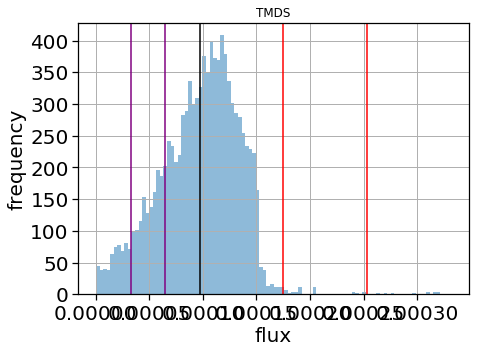

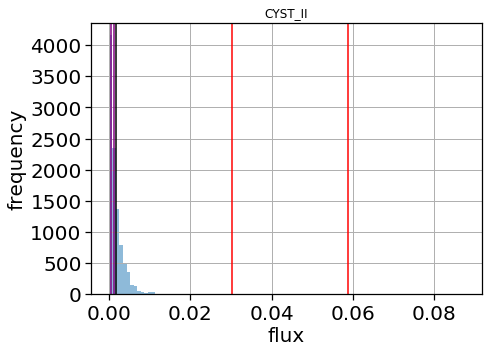

In [8]:
action_list = create_action_set(number_of_actions=4, add_no_change=False)
save_fig=True
for rxn_id in ["TMDS", "CYST_II"]:
    rc_dict, ax_rc = flux_constraint_hist(flux_samples_iEK_lb0, action_list, rxn_list=[rxn_id])
    ax_rc.set_ylabel("frequency")
    ax_rc.set_xlabel("flux")
    if save_fig==True:
        ax_rc.figure.savefig("cobra_model/figures_testing/"+rxn_id+"__model-"+MODEL_FILE.strip(".json")+"__actions-"+str(len(action_list))+"__fracbiomass-"+str(frac_biomass)+".png")
        ax_rc.figure.savefig("cobra_model/figures_testing/"+rxn_id+"__model-"+MODEL_FILE.strip(".json")+"__actions-"+str(len(action_list))+"__fracbiomass-"+str(frac_biomass)+".svg")

In [68]:
MODEL_FILE.strip(".json")

'iEK1011_M7H10_media'

In [62]:
FVA_CONSTRAINTS=True
FVA_frac_opt=0.0
FVA_pfba_fract = None
sol = COBRA_MODEL.optimize()
print("\t... before cleaning (objective_value: %f, DCPT flux: %f)" % (sol.objective_value, sol.fluxes["DCPT"]))
print("\t... before GEM= (genes: %d, reactions: %d, metabolites: %d)" % (len(COBRA_MODEL.genes), 
        len(COBRA_MODEL.reactions), len(COBRA_MODEL.metabolites)))
### Clean base model and apply FVA constriants
COBRA_MODEL = cs.clean_base_model(COBRA_MODEL, open_exchange=False, verbose=False)
sol = COBRA_MODEL.optimize()
print("\t... after cleaning (objective_value: %f, DCPT flux: %f)" % (sol.objective_value, sol.fluxes["DCPT"]))
if FVA_CONSTRAINTS==True:
    COBRA_MODEL, fva_df = cs.init_fva_constraints(COBRA_MODEL,opt_frac=FVA_frac_opt, pfba_fact=FVA_pfba_fract, verbose=False)
    sol = COBRA_MODEL.optimize()
    print("\t... after fva constraints (objective_value: %f, AFE flux: %f)" % (sol.objective_value, sol.fluxes["DCPT"]))
    print("\t... filtered GEM= (genes: %d, reactions: %d, metabolites: %d)" % (len(COBRA_MODEL.genes), 
        len(COBRA_MODEL.reactions), len(COBRA_MODEL.metabolites)))


	... before cleaning (objective_value: 0.058362, DCPT flux: 0.003029)
	... before GEM= (genes: 1011, reactions: 1229, metabolites: 998)
	... after cleaning (objective_value: 0.058362, DCPT flux: 0.003029)
	... after fva constraints (objective_value: 0.058362, AFE flux: 0.003029)
	... filtered GEM= (genes: 798, reactions: 911, metabolites: 728)


In [63]:
flux_samples_iEK_lb0_fvaNone = flux_analysis.sample(COBRA_MODEL, 10000,method='achr', 
                                        thinning=100, processes=6, seed=None)

0.017912975102769065 0.01606522896065294 0.12173991975840107 7.671100473314812e-07
ubs... 0.033978204063422 0.06610866198472788
2.762695301561109e-06 8.483536535049212e-07 6.9432114757712685e-06 1.5496903698808525e-10
ubs... 3.61104895506603e-06 5.307756262075873e-06
0.00019615136641083615 6.023310939884794e-05 0.0004929680147797579 1.100280162614334e-08
ubs... 0.0002563844758096841 0.00037685069460737994
0.08185420253383396 0.06726841467709949 0.570526759708857 1.1563748172876921e-05
ubs... 0.14912261721093345 0.2836594465651324
3.0234695476918566e-06 9.284308103739474e-07 7.59858984746682e-06 1.6959686662161385e-10
ubs... 3.951900358065804e-06 5.808761978813699e-06
1.531061733670724e-05 1.2667794025090767e-05 7.546192884377085e-05 9.821126279063295e-10
ubs... 2.7978411361798007e-05 5.331399941197954e-05
-0.01636523320730422 0.011468640595979629 -2.2102406827982494e-06 -0.0827044920703297
ubs... -0.00489659261132459 0.018040688580634668


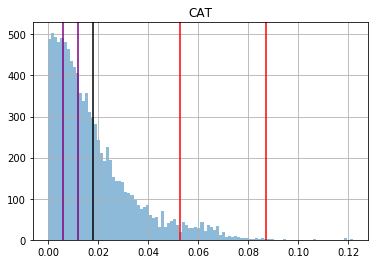

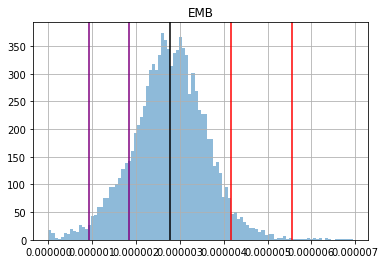

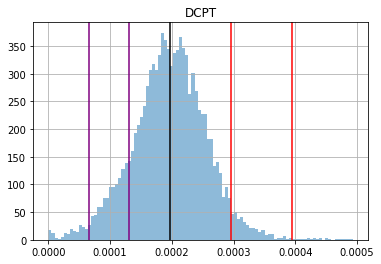

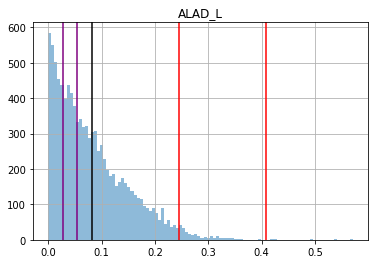

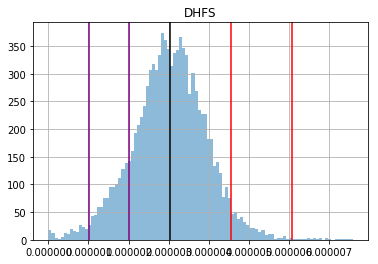

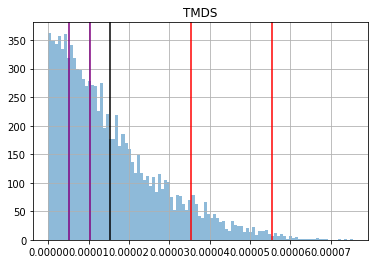

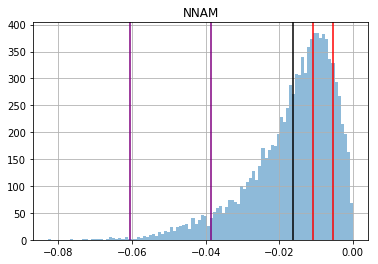

In [64]:
action_list = create_action_set(number_of_actions=4, add_no_change=False)

for rxn_id in ["CAT", "EMB", "DCPT", "ALAD_L", "DHFS", "TMDS", "NNAM"]:
    rc_dict, ax_rc = flux_constraint_hist(flux_samples_iEK_lb0_fvaNone, action_list, rxn_list=[rxn_id])

In [ ]:
popdf_median_sprice_anova_df.to_csv(ENSEMBLE_DIR+"/tables/strain_sprice_med_ANOVA_df_"+pheno_id+".csv")

Set lower bound on biomass and then sample and look at constraints

In [ ]:
flux_samples_iEK_lb0 = flux_analysis.sample(COBRA_MODEL, 10000,method='achr', 
                                        thinning=100, processes=6, seed=None)

In [ ]:
rc_dict, ax_rc = flux_constraint_hist(flux_samples_iEK_lb0, action_list, rxn_list=["CAT"])

Check out what iNJ661 all about yo

In [73]:
DATA_DIR = "cobra_model/"
MODEL_FILE = "iNJ661.json"#"iEK1011_drugTesting_media.json"
INJ_MODEL = load_json_model(DATA_DIR+MODEL_FILE)
# INJ_MODEL.reactions.get_by_id("ARGDr").lower_bound=0
# INJ_MODEL.reactions.get_by_id("ALATA_L").lower_bound=0
# INJ_MODEL.reactions.get_by_id("GLUDxi").lower_bound=0
# inj_sol =INJ_MODEL.optimize()
print(inj_sol.objective_value)
print(inj_sol.fluxes["EX_o2_e"])
print(inj_sol.fluxes["EX_nh4_e"])
print(inj_sol.fluxes["EX_glu__L_e"])
print(inj_sol.fluxes['EX_h2o_e'])
print(inj_sol.fluxes["H2Ot"])
# COBRA_MODEL.reactions.get_by_id("BIOMASS_Mtb_9_60atp").lower_bound = sol.objective_value*0.1
inj_sol.fluxes.sort_values()

0.049165124845941564
-1.0
-0.10672091739346497
-0.21465159184888974
0.8185505038598582
-0.8185505038598582


PGK           -2.827562
PGM           -2.780629
L_LACt2r      -1.709482
LDH_L         -1.709482
H2CO3TP       -1.109751
EX_o2_e       -1.000000
GLYCt         -1.000000
EX_glyc_e     -1.000000
EX_glc__D_e   -1.000000
G3PD1ir       -0.994073
G6PP          -0.991979
H2Ot          -0.818551
SUCCt2r       -0.459423
PPCK          -0.289142
FORMCOAL      -0.279317
CITL_copy1    -0.279317
FRDO3r        -0.270338
ACKr          -0.259900
EX_glu__L_e   -0.214652
EX_nh4_e      -0.106721
ASPTA         -0.105083
PEPCK_re      -0.095258
PIt           -0.054489
EX_pi_e       -0.054489
RPE           -0.032974
RPI           -0.031824
IMPC          -0.021310
KARA1         -0.020184
ORPT          -0.019453
DHORTS        -0.019453
                 ...   
ACONT          0.279317
ICL            0.279317
OXACOAL        0.279317
GLXO1          0.279317
OXCDC          0.279317
ACCOAC         0.318506
HCO3E          0.343879
EX_succ_e      0.459423
PFL            0.633549
EX_h2o_e       0.818551
ATPS4r         0

In [75]:
for rxn in INJ_MODEL.metabolites.get_by_id("atp_c").reactions:
    print(rxn.reaction)

atp_c + rib__D_c --> adp_c + h_c + r5p_c
atp_c + h_c + nicrnt_c --> dnad_c + ppi_c
atp_c + cbl1_c + h_c <=> adocbl_c + pppi_c
arab__D_e + atp_c + h2o_c --> adp_c + arab__D_c + h_c + pi_c
atp_c + gtp_c + h2o_c + so4_c --> aps_c + gdp_c + pi_c + ppi_c
5aizc_c + asp__L_c + atp_c <=> 25aics_c + adp_c + h_c + pi_c
ac_c + atp_c <=> actp_c + adp_c
atp_c + glu__L_c + thf_c <=> adp_c + h_c + pi_c + thfglu_c
atp_c + h2o_c + malthp_e --> adp_c + h_c + malthp_c + pi_c
atp_c + coa_c + hdcea_c <=> amp_c + hdcoa_c + ppi_c
atp_c + ump_c --> adp_c + udp_c
atp_c + cbi_c + h_c <=> adocbi_c + pppi_c
atp_c + gsn_c --> adp_c + gmp_c + h_c
atp_c + dgmp_c <=> adp_c + dgdp_c
atp_c + btn_c + h_c --> btamp_c + ppi_c
atp_c + h2o_c + malt_e --> adp_c + h_c + malt_c + pi_c
6hmhpt_c + atp_c --> 6hmhptpp_c + amp_c + h_c
atp_c + coa_c + hdca_c <=> amp_c + pmtcoa_c + ppi_c
atp_c + glc__D_c --> adp_c + g6p_c + h_c
atp_c + fmn_c + h_c --> fad_c + ppi_c
amp_c + atp_c <=> 2.0 adp_c
adp_c + 4.0 h_e + pi_c <=> atp_c + h2o_c 

In [ ]:
for metab in INJ_MODEL.reactions.get_by_id("BIOMASS_Mtb_9_60atp").metabolites:
    print(metab.id, INJ_MODEL.reactions.get_by_id("BIOMASS_Mtb_9_60atp").get_coefficient(metab))

In [10]:
INJ_MODEL.medium

{'EX_k_e': 1.0,
 'EX_h_e': 1.0,
 'EX_h2o_e': 1.0,
 'EX_h2co3_e': 999999.0,
 'EX_glyc_e': 1.0,
 'EX_glu__L_e': 1.0,
 'EX_glc__D_e': 1.0,
 'EX_fe3_e': 1.0,
 'EX_cu2_e': 1.0,
 'EX_cl_e': 1.0,
 'EX_cit_e': 1.0,
 'EX_ca2_e': 1.0,
 'EX_so4_e': 1.0,
 'EX_pi_e': 1.0,
 'EX_o2_e': 1.0,
 'EX_nh4_e': 1.0,
 'EX_na1_e': 1.0}

In [ ]:
rxn_flux_samples_ARCH = flux_analysis.sample(COBRA_MODEL, 10000,method='achr', 
                                      thinning=100, processes=6, seed=None)

Phase plane analysis of models

In [12]:
from cobrascape.plotting import PhPP_plot
from cobra.flux_analysis import production_envelope

In [ ]:
obj_rxn_popfva = "AFE_max"
obj_1, obj_2 = "DCPT_max", "AFE_max"
DATA_DIR = "cobra_model/"
MODEL_FILE = "iNJ661.json"#"iEK1011_drugTesting_media.json"
INJ_MODEL = load_json_model(DATA_DIR+MODEL_FILE)
num_points = 30
obj_rxn = obj_rxn_popfva.strip("_max").strip("_min")
flux_1, flux_2 = obj_1.strip("_max").strip("_min"), obj_2.strip("_max").strip("_min")
obj_direct = obj_rxn_popfva.split("_")[-1]+"imum" # "maximum"
prod_env = production_envelope(INJ_MODEL, [flux_1, flux_2], objective=obj_rxn, 
                           points=num_points)

f, ax_PhPP = PhPP_plot(flux_1,flux_2,prod_env.fillna(0),obj_direct=obj_direct,labelsizes=15,surf_trans=0.4)
f

# Sampling constraints statistics

In [ ]:
import scipy
import scipy.stats

import matplotlib
import matplotlib.pyplot as plt
class Distribution(object):
    
    def __init__(self,dist_names_list = []):
        self.dist_names = ['norm','lognorm','expon']
        self.dist_results = []
        self.params = {}
        
        self.DistributionName = ""
        self.PValue = 0
        self.Param = None
        
        self.isFitted = False
        
        
    def Fit(self, y):
        self.dist_results = []
        self.params = {}
        for dist_name in self.dist_names:
            dist = getattr(scipy.stats, dist_name)
            param = dist.fit(y)
            
            self.params[dist_name] = param
            #Applying the Kolmogorov-Smirnov test
            D, p = scipy.stats.kstest(y, dist_name, args=param);
            self.dist_results.append((dist_name,p))

        #select the best fitted distribution
        sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
        #store the name of the best fit and its p value
        self.DistributionName = sel_dist
        self.PValue = p
        
        self.isFitted = True
        return self.DistributionName,self.PValue
    
    def Random(self, n = 1):
        if self.isFitted:
            dist_name = self.DistributionName
            param = self.params[dist_name]
            #initiate the scipy distribution
            dist = getattr(scipy.stats, dist_name)
            return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
        else:
            raise ValueError('Must first run the Fit method.')
            
    def Plot(self,y):
        x = self.Random(n=len(y))
        plt.hist(x, alpha=0.5, label='Fitted')
        plt.hist(y, alpha=0.5, label='Actual')
        plt.legend(loc='upper right')